In [16]:
import numpy as np
import torch
from torch_geometric.data import Data
import pandas as pd
from torch_geometric import utils
import networkx as nx
from pyvis.network import Network
from torch_geometric.transforms import RandomLinkSplit
import torch.nn.functional as F
from torch.nn import ModuleList, Linear, Dropout, Module, Sequential
from torch_geometric.nn import SAGEConv
from dataclasses import dataclass
from torch_geometric.loader import LinkNeighborLoader
from tqdm import tqdm
from torch_geometric.nn import MessagePassing

In [2]:
data = pd.read_csv("Amazon0302.txt", sep="\t", skiprows=4, names=["src", "dst"])

In [3]:
data.head()

,src,dst
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [4]:
print(f"Nodes = {len(data.dst.unique())}")
print(f"Edges = {len(data)}")

Nodes = 262111
Edges = 1234877


In [5]:
node_feature = torch.rand(len(data.dst.unique()), 1)

In [6]:
edge_index = torch.tensor(data.to_numpy().T)

In [7]:
graph = Data(x=node_feature, edge_index=edge_index)
graph

Data(x=[262111, 1], edge_index=[2, 1234877])

In [8]:
mask = np.zeros(graph.x.shape[0])
mask[:100] = 1
mask = torch.tensor(mask == 1)

In [9]:
vis_graph = Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])

In [10]:
networkx_graph = utils.to_networkx(vis_graph)
pyvis_graph = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
pyvis_graph.from_nx(networkx_graph)

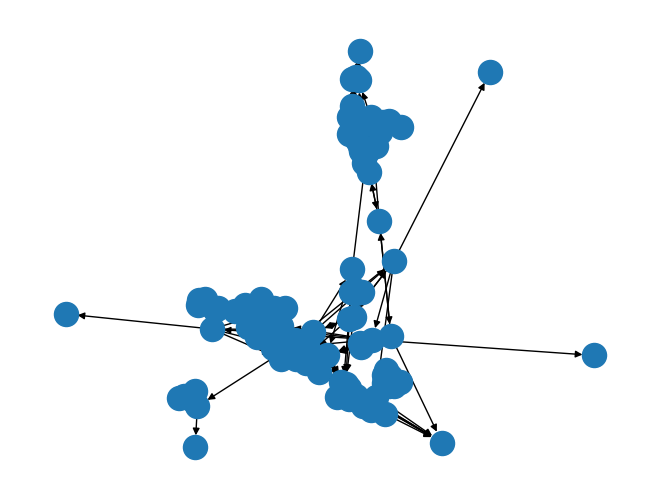

In [11]:
nx.draw(networkx_graph)

In [12]:
pyvis_graph.show("graph.html")

graph.html


In [13]:
transform = RandomLinkSplit(num_test=5000, num_val=5000,split_labels=False, 
    add_negative_train_samples=False)
train, test, val = transform(graph)

In [18]:
train_loader = LinkNeighborLoader(train, num_neighbors=[25, 10], batch_size=1024,
                                      neg_sampling_ratio=1.0, edge_label=train.edge_label,
                                      edge_label_index=train.edge_label_index,shuffle=True)
val_loader = LinkNeighborLoader(val, num_neighbors=[25, 10], edge_label=val.edge_label,
                                    edge_label_index=val.edge_label_index, batch_size=1024)
test_loader = LinkNeighborLoader(test, num_neighbors=[25, 10], edge_label=test.edge_label,
                                     edge_label_index=test.edge_label_index, batch_size=1024)

In [19]:
sample = next(iter(train_loader))
print(sample)

Data(x=[56070, 1], edge_index=[2, 105136], edge_label=[2048], edge_label_index=[2, 2048], n_id=[56070], e_id=[105136], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[1024])


In [24]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, aggr="add"):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, normalize=True, aggr=aggr))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
        self.convs.append(SAGEConv(hidden_channels, out_channels, normalize=True, aggr=aggr))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

In [25]:
class NeuralLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(NeuralLinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x).squeeze()

In [31]:
class EdgeClassificationSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layer, dropout):
        super().__init__()
        self.encode = SAGE(in_channels,hidden_channels, hidden_channels, num_layer, dropout)
        self.decode = NeuralLinkPredictor(hidden_channels, hidden_channels, 1, num_layer+1, dropout)
    
    def forward(self, x, edge_index, pred_edge_index):
        z = self.encode(x, edge_index)
        row, col = pred_edge_index
        z_src = z[row]
        z_dst = z[col]
        return self.decode(z_src, z_dst)

In [32]:
@dataclass
class Config:
    optim_wd = 0
    epochs = 300
    hidden_dim = 1024
    dropout = 0.2
    num_layers = 2
    lr = 1e-5
    node_emb_dim = 1
    batch_size = 1024

In [33]:
config = Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train.to(device)
val.to(device)

model = EdgeClassificationSAGE(config.node_emb_dim, config.hidden_dim, 
                               config.num_layers, config.dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.optim_wd)

In [36]:
def train_edge_classification(model, train_loader, val_loader, num_epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    best_val_auc = 0

    loss_track = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, f"Epoch {epoch+1}: "):
            optimizer.zero_grad()
            
            out = model(batch.x, batch.edge_index, batch.edge_label_index)
            loss = F.binary_cross_entropy_with_logits(out, batch.edge_label)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        loss_track.append(total_loss/len(train_loader))
        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                out = model(batch.x, batch.edge_index, batch.edge_label_index)
                val_preds.append(out)
                val_labels.append(batch.edge_label)
        
        val_preds = torch.cat(val_preds, dim=0)
        val_labels = torch.cat(val_labels, dim=0)
        val_auc = roc_auc_score(val_labels.cpu(), val_preds.cpu())
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
        
        print(f'Epoch {epoch+1:03d}, Loss: {total_loss/len(train_loader):.4f}, Val AUC: {val_auc:.4f}')

    return loss_track

In [37]:
loss = train_edge_classification(model, train_loader, val_loader, 1)

Epoch 1:   0%|▏                                                                      | 4/1197 [01:14<6:11:35, 18.69s/it]


KeyboardInterrupt: 

In [ ]:
plt.title("Loss")
plt.xlabel("Epoch")
plt.plot(loss)